In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from functools import reduce

/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_43489/220279590.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
df = pd.read_csv('../data/summary_by_domain.csv')


In [6]:
# Sum Archaea + Bacteria per query_name
arch_bac = df[df["domain"].isin(["d__Archaea", "d__Bacteria"])]
arch_bac_sum = arch_bac.groupby("query_name", as_index=False)[["f_unique_weighted", "total_weighted_hashes"]].sum()
arch_bac_sum["domain"] = "Archaea+Bacteria"

# Remove original Archaea/Bacteria rows and append combined
df = df[~df["domain"].isin(["d__Archaea", "d__Bacteria"])]
df = pd.concat([df, arch_bac_sum], ignore_index=True)

In [7]:
df

,domain,query_name,f_unique_weighted,total_weighted_hashes,source_file
0,Eukaryota,SRR16235702,0.002581,14246726,SRR16235702.k31.s10k.gather.with-lineages.csv
1,plasmids,SRR16235702,0.410930,1095902,SRR16235702.k31.s10k.gather.with-lineages.csv
2,vOTUs,SRR16235702,0.084143,1095902,SRR16235702.k31.s10k.gather.with-lineages.csv
3,Eukaryota,SRR11125386,0.000239,452757,SRR11125386.k31.s10k.gather.with-lineages.csv
4,plasmids,SRR11125386,0.122198,150919,SRR11125386.k31.s10k.gather.with-lineages.csv
...,...,...,...,...,...
617,Archaea+Bacteria,SRR8960923,0.618932,827712900,NaN
618,Archaea+Bacteria,SRR8960932,0.621049,1037997018,NaN
619,Archaea+Bacteria,SRR8960950,0.526448,1371542438,NaN
620,Archaea+Bacteria,SRR8960959,0.491484,1658999188,NaN


In [8]:
df['domain'].value_counts()

domain
Eukaryota                                                            150
plasmids                                                             150
vOTUs                                                                150
Archaea+Bacteria                                                     150
GCA_029289425.3 pygmy chimpanzee (Pan paniscus)                       10
GCA_002575655.3 Aegilops tauschii subsp. strangulata                   8
GCA_011762505.2 Nile rat (Arvicanthis niloticus)                       2
GCA_029281585.3 western lowland gorilla (Gorilla gorilla gorilla)      1
GCA_922984935.2 Eurasian badger (Meles meles)                          1
Name: count, dtype: int64

In [9]:
# Merge GCA_* domains into Eukaryotes
df.loc[df["domain"].str.startswith("GCA_"), "domain"] = "Eukaryota"

# Sum numeric values for duplicates that now have the same domain/query_name
df = df.groupby(["query_name", "domain"], as_index=False)[["f_unique_weighted", "total_weighted_hashes"]].sum()

# Calculate total f_unique_weighted per query_name
totals = df.groupby("query_name", as_index=False)["f_unique_weighted"].sum()
totals["domain"] = "Total"

In [10]:
# all 150
df['domain'].value_counts()

domain
Archaea+Bacteria    150
Eukaryota           150
plasmids            150
vOTUs               150
Name: count, dtype: int64

In [13]:
# add sums to df
df_plot = pd.concat([df, totals], ignore_index=True)
(len(df_plot))

750

In [14]:
df_plot

,query_name,domain,f_unique_weighted,total_weighted_hashes
0,ERR1135178,Archaea+Bacteria,0.542906,2.050525e+09
1,ERR1135178,Eukaryota,0.002335,4.043630e+06
2,ERR1135178,plasmids,0.089185,4.043630e+05
3,ERR1135178,vOTUs,0.172714,4.043630e+05
4,ERR1135230,Archaea+Bacteria,0.439731,2.848378e+09
...,...,...,...,...
745,SRR8960923,Total,0.821248,NaN
746,SRR8960932,Total,0.826535,NaN
747,SRR8960950,Total,0.789511,NaN
748,SRR8960959,Total,0.815396,NaN


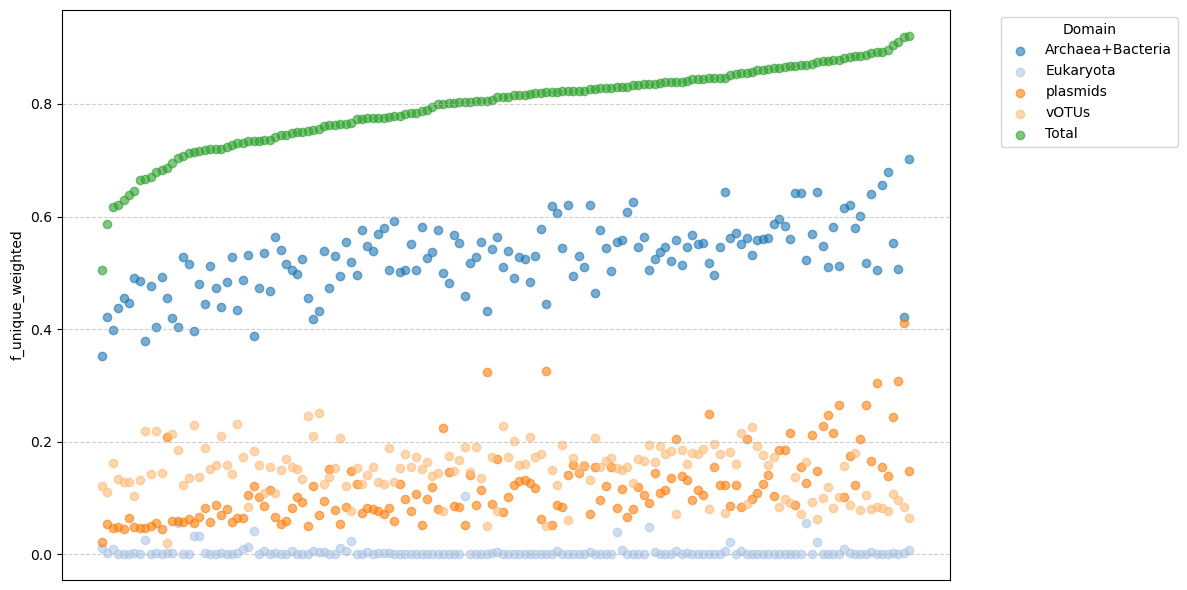

In [15]:
# Determine order of query_name by total descending
order = totals.sort_values("f_unique_weighted", ascending=True)["query_name"].tolist()
query_to_x = {q: i for i, q in enumerate(order)}

plt.rcParams["figure.figsize"] = (12, 6)

domains = df_plot["domain"].unique()
colors = plt.cm.tab20.colors  # up to 20 distinct colors

for i, domain in enumerate(domains):
    sub = df_plot[df_plot["domain"] == domain]
    x = sub["query_name"].map(query_to_x)  # convert names to numeric positions
    plt.scatter(x, sub["f_unique_weighted"], 
                color=colors[i % len(colors)], alpha=0.6, label=domain)

plt.ylabel("f_unique_weighted")
plt.xticks([])  # or use plt.xticks(range(len(order)), order, rotation=90) if you want labels
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig("../plots/domain_dotplot_sorted.png")
plt.show()
